# **Antonio Payar Sánchez**

---



<span style="color: red;">(Este grafico se ve al ejecutar la ultima celda, tuve que borrar la ejucución para cumplir con el tamaño maximo de Github)</span>

El grafico representa las intervenciones que hace nuestro agente en la bolsa

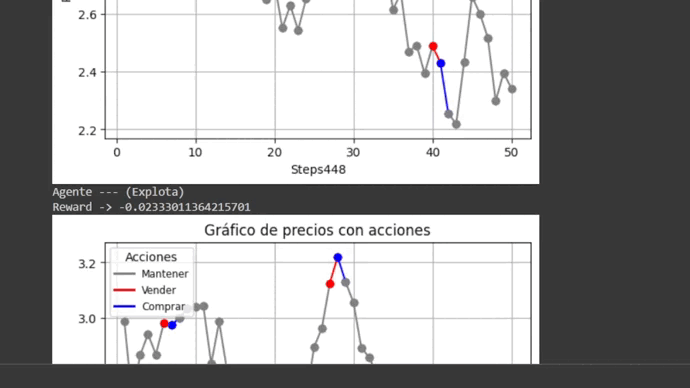


Este trabajo nace como una práctica que tenía que realizar para la última asignatura de 4º de Ingeniería de Software, Aprendizaje Automático II.

El principal objetivo del trabajo era **explorar superficialmente** en qué consistía el Reinforcement Learning. Para ello, el profesor puso como ejemplo un trabajo sobre un agente que operaba en la bolsa y obtenía una cierta recompensa, pero sin llegar a ser un DQN.

![DQN](https://www.researchgate.net/profile/Sebastian-Lang/publication/347464621/figure/fig1/AS:970140451606530@1608310916620/Concept-of-DQN-Every-time-the-replay-memory-has-been-updated-DQN-generates-a-mini-batch.png)



****Por ello mismo decidi empezar de nuevo el trabajo aplicando los conceptos reales de las DQN.****


Al principio, mis mayores preocupaciones giraban en torno a la complejidad que consideraba que tendría la creación del agente a nivel de desarrollo. Sin embargo, conforme avancé con ello, vi que dentro del DQN, tanto la creación del agente como la memoria son bastante "monolíticas" y no requieren grandes invenciones.

Lo que realmente resultó complicado fue desarrollar el entorno (Environment), dado que, a pesar de parecer un problema sencillo a priori (un agente que compra, vende o mantiene), el principal desafío es la optimización de la función de recompensa.

Uno de los problemas curiosos a los que me enfrenté al crear el Agente fue la cantidad de información que se le debe proporcionar para que sepa qué movimiento realizar.

Para ello, inicialmente le pasaba la información que me daba el dataset de cada uno de los días que transcurrían. Sin embargo, esa información es muy limitada, ya que solo incluye el precio de cierre y poco más, lo que no proporciona suficiente contexto al agente para decidir la siguiente acción. Por esta razón, decidí aplicar una red neuronal independiente (ARIMA) de la de DQN que, mediante el historial de precios anteriores, predice cuál será el precio del día siguiente.

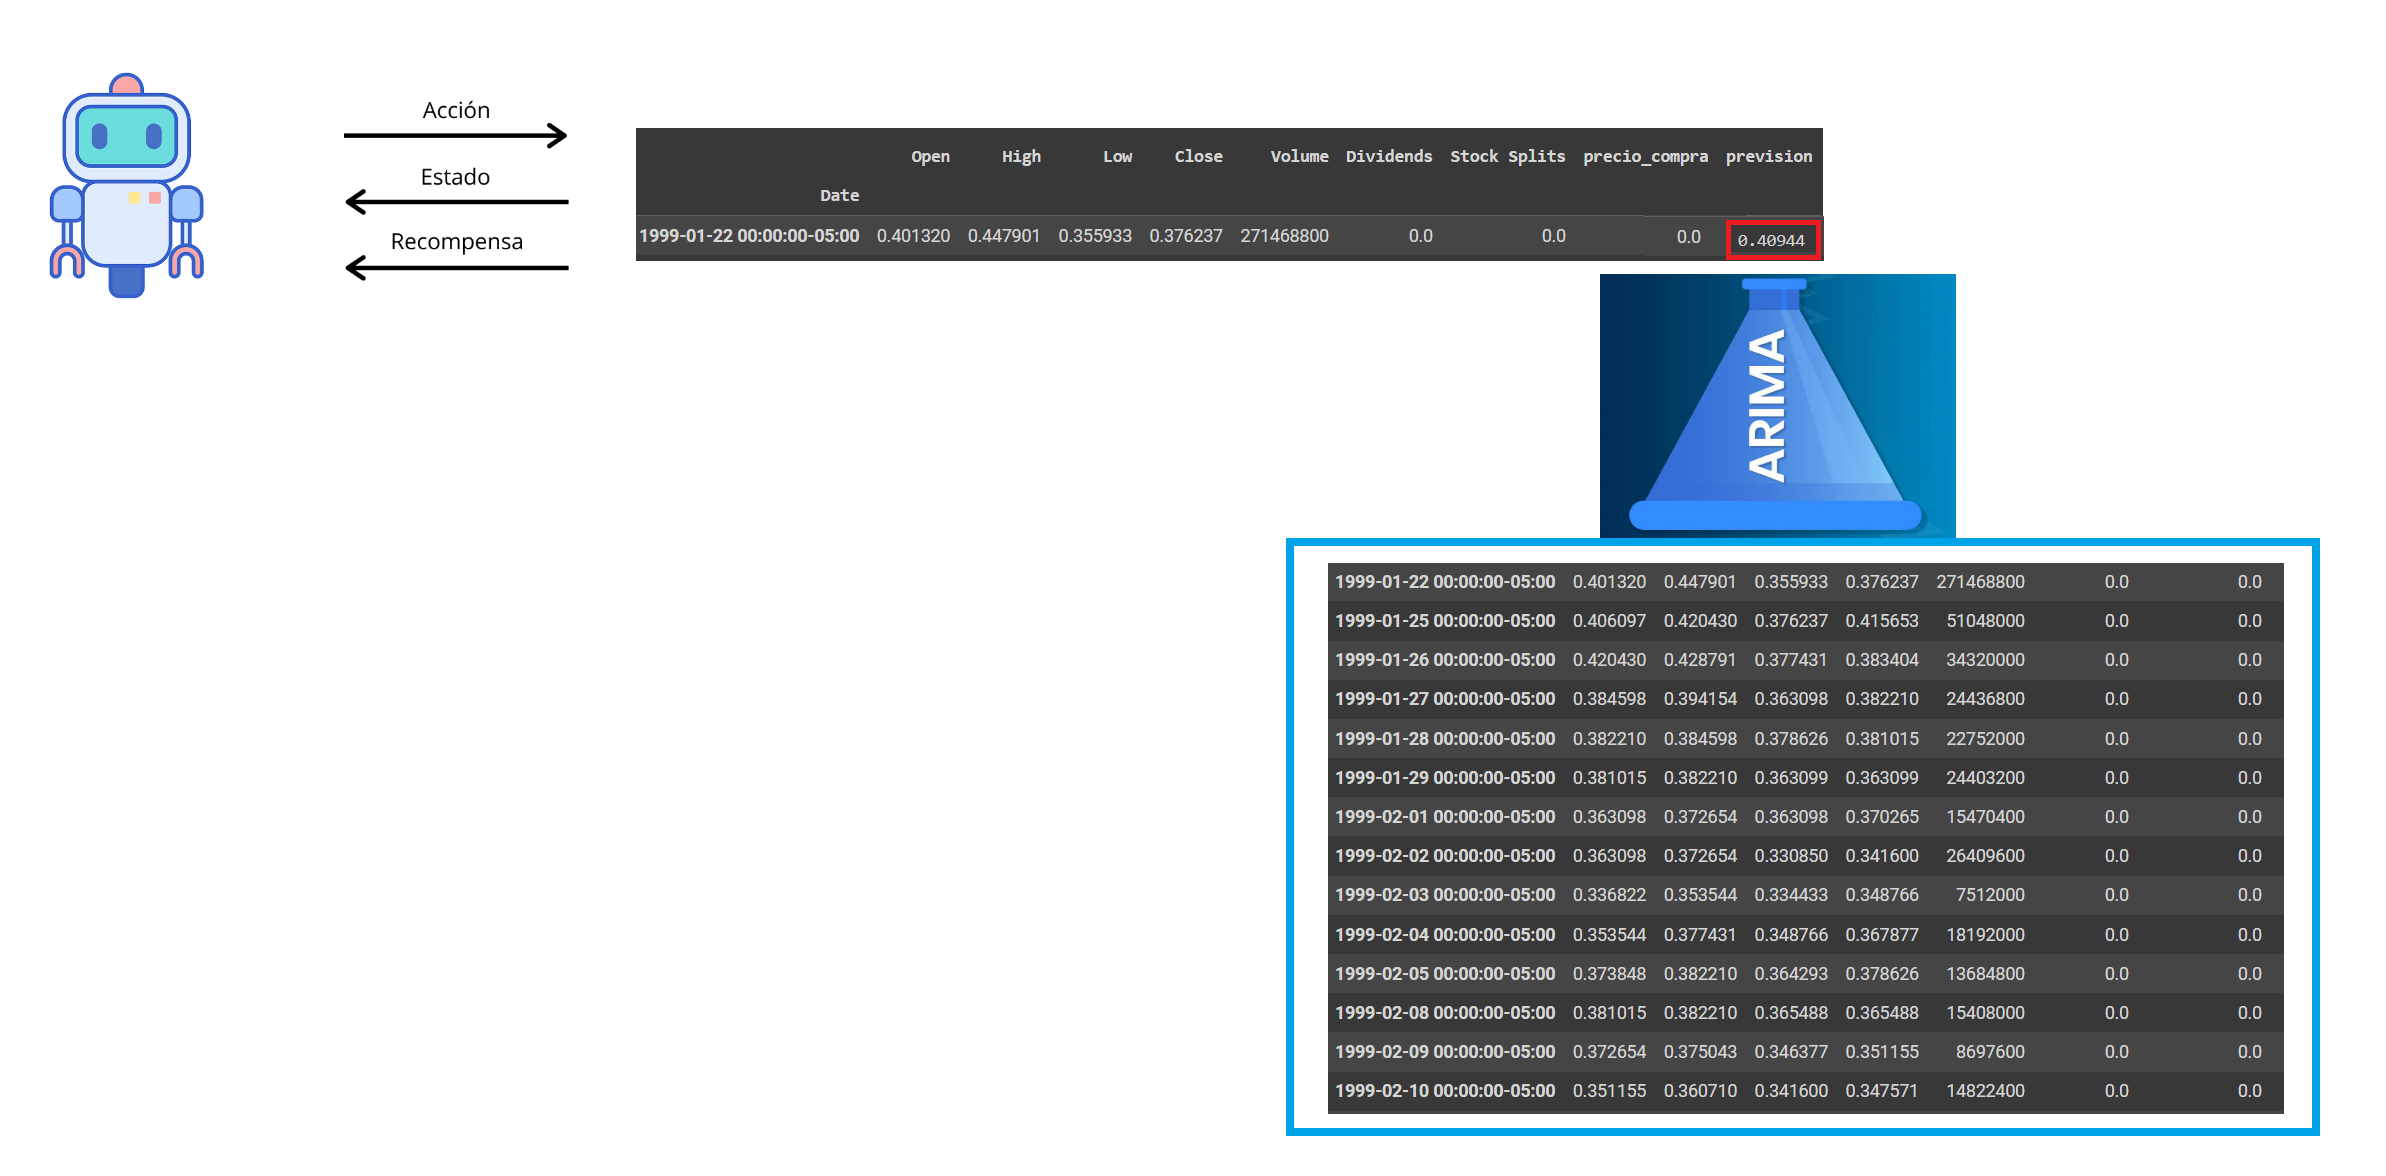


Lamentablemente, tuve que comentar este código, ya que el tiempo de entrenamiento se multiplicaba en horas. Como compensación, lo reemplacé por una técnica que proporciona el precio del día siguiente aplicando un error aleatorio al resultado.


En las diferentes pruebas que realicé con la función de recompensa, me encontré con problemas tan curiosos como:

*   El Agente solo queria comprar y vender
*   El Agente intentaba vender constantemente.
*   El agente mantenia hasta el final.

Finalmente, al optimizar las recompensas que le iba dando al agente, logré que hubiera cierta sinergia entre las operaciones. Sin embargo, dado que el conjunto de datos era el precio de mercado de Nvidia, mi agente no era tonto y veía que mantener la compra era la mejor estrategia, dado lo rápido que ha subido el precio de sus acciones durante los últimos años.

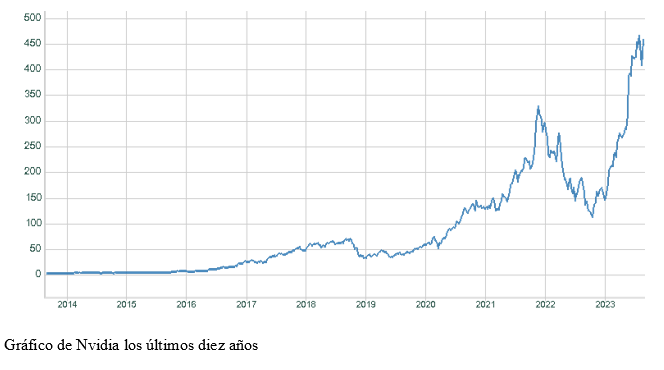



Para ello me inspire de diversas fuentes:

https://arxiv.org/abs/1312.5602

https://www.youtube.com/watch?v=x83WmvbRa2I

https://www.youtube.com/watch?v=wrBUkpiRvCA


In [ ]:
# !pip install yfinance
# !pip install statsmodels
import time
import yfinance as yf
import gym
from gym import spaces
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [ ]:
df = yf.Ticker("NVDA").history(period="max")
df['precio_compra'] = 0.0   # Añadimos una columna para meter el precio de compra de las acciones en el environmet
df['prevision'] = 0.0
print(df.head())
matriz = df.values  # Convertir DataFrame a matriz numpy
print(len(df))

                               Open      High       Low     Close     Volume  \
Date                                                                           
1999-01-22 00:00:00-05:00  0.401320  0.447901  0.355933  0.376237  271468800   
1999-01-25 00:00:00-05:00  0.406097  0.420430  0.376237  0.415652   51048000   
1999-01-26 00:00:00-05:00  0.420430  0.428791  0.377431  0.383404   34320000   
1999-01-27 00:00:00-05:00  0.384598  0.394154  0.363098  0.382210   24436800   
1999-01-28 00:00:00-05:00  0.382210  0.384598  0.378626  0.381015   22752000   

                           Dividends  Stock Splits  precio_compra  prevision  
Date                                                                          
1999-01-22 00:00:00-05:00        0.0           0.0            0.0        0.0  
1999-01-25 00:00:00-05:00        0.0           0.0            0.0        0.0  
1999-01-26 00:00:00-05:00        0.0           0.0            0.0        0.0  
1999-01-27 00:00:00-05:00        0.0        

# Agente - Memoria - Envirionment

In [ ]:
class QNetwork(keras.Model):
    def __init__(self, input_dims, n_actions, lr):
        super(QNetwork, self).__init__()
        self.fc0 = Dense(128, input_shape=(input_dims,), activation='relu')
        self.fc2 = Dense(64, activation='relu')
        self.fc3 = Dense(32, activation='relu')
        self.fc4 = Dense(n_actions, activation='linear')

    def call(self, state):
        x = self.fc0(state)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [ ]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.size = max_size
        self.contador = 0

        self.estado_memory = np.zeros((self.size, *input_shape),dtype=np.float64)
        self.new_estado_memory = np.zeros((self.size, *input_shape),dtype=np.float64)

        self.action_memory = np.zeros(self.size, dtype=np.int64)
        self.reward_memory = np.zeros(self.size, dtype=np.float64)
        self.terminal_memory = np.zeros(self.size, dtype=bool)

    def store_transition(self, observation, action, reward, observation_, done):
        index = self.contador % self.size
        self.estado_memory[index] = observation
        self.new_estado_memory[index] = observation_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.contador = self.contador + 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.contador, self.size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        estados = self.estado_memory[batch]
        acciones = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        estados_futuro = self.new_estado_memory[batch]
        terminal = self.terminal_memory[batch]

        return estados, acciones, rewards, estados_futuro, terminal

In [ ]:
class Agent:
    def __init__(self, gamma, epsilon,eps_min,eps_dec, lr, n_actions, input_dims,mem_size, batch_size):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = 1000
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0
        self.compra_realizada = False
        self.venta_realizada = False

        #Instanciamos Memoria
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        #Q-Network y Target-Network
        self.q_eval = QNetwork(input_dims, n_actions,lr)
        self.q_next = QNetwork(input_dims, n_actions,lr)

        #Compilamos Redes
        self.q_eval.compile(optimizer=Adam(learning_rate=lr))
        self.q_eval(np.zeros((1, input_dims[0])))
        self.q_next.compile(optimizer=Adam(learning_rate=lr))
        self.q_next(np.zeros((1, input_dims[0])))

    def save_models(self):
      self.q_eval.save(str(self.learn_step_counter)+'q_eval')
      self.q_next.save(str(self.learn_step_counter)+'q_next')
      print('... models saved successfully ...')

    def load_models(self):
      self.q_eval = keras.models.load_model(str(self.learn_step_counter)+'q_eval')
      self.q_next = keras.models.load_model(str(self.learn_step_counter)+'q_next')
      print('... models loaded successfully ...')

    def store_transition(self, state, action, reward, state_, done):
      self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
      state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
      states = tf.convert_to_tensor(state)
      rewards = tf.convert_to_tensor(reward)
      dones = tf.convert_to_tensor(done)
      actions = tf.convert_to_tensor(action, dtype=tf.int32)
      states_ = tf.convert_to_tensor(new_state)
      return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        if self.compra_realizada == False and self.venta_realizada == False:
          action = 0
        else :
          if np.random.random() > self.epsilon:
              print("Agente --- (Explota)")

              state = tf.convert_to_tensor([observation])
              actions = self.q_eval(state)#       Predict() siguiente_accion
              action = tf.math.argmax(actions, axis=1).numpy()[0]

              if self.compra_realizada == True and action==0:
                  action = 2 # (Mantiene))
              if self.venta_realizada == True and action==1:
                  action = 2 # (Mantiene))
          else:
              print("Agente --- Explora")

              if self.compra_realizada == True and self.venta_realizada == False:
                  action = np.random.choice([1, 2]) # No puede dar 0(Comprar)
              elif self.compra_realizada == False and self.venta_realizada == True:
                  action = np.random.choice([0, 2]) # No puede dar 1(Vender)
              else:
                  action = np.random.choice(self.action_space)

        self.actualizar_compra_realizada(action)
        return action

    def actualizar_compra_realizada(self,action):
        if action == 0:
            self.compra_realizada = True
            self.venta_realizada = False

        if action == 1:
            self.compra_realizada = False
            self.venta_realizada = True

    def replace_target_network(self):
      # copia los pesos de la red principal (q_eval) a la red objetivo (q_next).
      if self.learn_step_counter % self.replace_target_cnt == 0:
          self.q_next.set_weights(self.q_eval.get_weights())

    def decrement_epsilon(self):
      if self.epsilon > self.eps_min:
          self.epsilon = self.epsilon - self.eps_dec
      else:
          self.epsilon = self.eps_min

    def learn(self):
      #Verificar si hay suficientes muestras en la memoria
      if self.memory.contador < self.batch_size:
          return

      #Actualizamos pesos red principal y objetivo
      self.replace_target_network()

      states, actions, rewards, next_states, dones = self.sample_memory()

      #--------------------fit()--------------------------------------
      indices = tf.range(self.batch_size, dtype=tf.int32)
      exit()
      action_indices = tf.stack([indices, actions], axis=1)

      #Cálculo de la función de pérdida
      with tf.GradientTape() as tape:
          #Predict accion para estado actual
          q_pred = tf.gather_nd(self.q_eval(states), indices=action_indices)

          #Obtenemos los estados siguientes
          q_next = self.q_next(next_states)
          max_actions = tf.math.argmax(q_next, axis=1, output_type=tf.int32)  # Obtenemos el mayor Q_value de la prediccion
          max_action_idx = tf.stack([indices, max_actions], axis=1)

          #Predict accion para estado furturo
          max_pred_q_values = tf.gather_nd(q_next, indices=max_action_idx)

          # Formula_actualizacion_funcion_q
          max_pred_q_values = tf.cast(max_pred_q_values, dtype=tf.float64)  #Casteamos para que el tensorf tenga el mismo dtype
          #Ecuacion de Bellman
          q_target = rewards + self.gamma* max_pred_q_values * (1 - dones.numpy().astype(np.float64))

          #Actualizamos la loss con la q_predicha y la q_objetivo
          loss = keras.losses.MSE(q_pred, q_target)

      #Necesitamos los parametros para actualizar la q_eval
      params = self.q_eval.trainable_variables
      #  .fit()
      grads = tape.gradient(loss, params)

      #Actualizamos los parametros
      self.q_eval.optimizer.apply_gradients(zip(grads, params))
      self.learn_step_counter = self.learn_step_counter + 1
      self.decrement_epsilon()

In [ ]:
class StockTradingEnvironment(gym.Env):
    def __init__(self, data, df):
        super(StockTradingEnvironment, self).__init__()

        self.data = data
        self.data_frame = df
        self.model_arima = None
        self.current_step = None
        self.current_price = None
        self.precio_compra = None
        self.iteraciones_manteniendo = None
        self.precio_venta = None
        # Acciones:
        #   Comprar,
        #   Vender,
        #   Mantener
        self.action_space = spaces.Discrete(3)

        # Hay 7 componentes en la observación (Estados).
        #   Open
        #   High
        #   Low
        #   Close
        #   Volumen ...
        forma = (9,)
        #Definido el límite inferior (low) como 0
        # no tiene sentido que ninguna de las características del estado sea negativa.
        # Por ejemplo : Open o Close no pueden ser negativos.
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=forma, dtype=np.float32)
        #límite superior (high) como infinito (np.inf)
        #para permitir que las características del estado tomen cualquier valor positivo,
        #que no hay límites superiores predefinidos para el saldo en efectivo o el precio de las acciones.

    def reset(self):
      self.current_step = 0
      self.current_price = self.data[self.current_step][3]
      self.iteraciones_manteniendo = 0
      self.precio_compra = 0
      self.precio_venta = 0
      return self.siguiente_observacion()

    def prediccion_precio(self):
      if self.fin_dataframe() == False :
        self.data[self.current_step][8] = self.data[self.current_step+1][3] + np.random.uniform(-0.2, 0.2)
      # train = self.data_frame[:self.current_step]
      # # Filtrar las advertencias
      # with warnings.catch_warnings():
      #   warnings.simplefilter("ignore")
      #   self.model_arima = ARIMA(train['Close'], order=(10,1,10))
      #   self.model_arima = self.model_arima.fit()
      #   self.data[self.current_step][8] = self.model_arima.forecast(steps=1)#   Añadimos la prediccion al entorno


    def siguiente_observacion(self):
      if self.current_step > 10:
        self.prediccion_precio() # Añadimos la prediccion a la siguiente observacion del entorno
      return np.array(self.data[self.current_step])

    def step(self, action):
        # Obtenemos los estado antes de cambiar de paso
        anterior_observation = self.siguiente_observacion()

        if action == 0:  # Comprar
            print("Compra")
            self.precio_compra = self.current_price
            self.iteraciones_manteniendo = 0
            self.precio_venta = 0
            self.data[self.current_step][7] = self.precio_compra
            self.data[self.current_step + 1][7] = self.precio_compra #    Añadimos a los datos el precio al que hemos comprado
        elif action == 1:  # Vender
            print("Vende")
            self.precio_venta = self.current_price
            self.data[self.current_step][7] = self.precio_compra
            self.data[self.current_step + 1][7] = 0.0
        elif action == 2 and self.precio_compra != 0: #   Mantiene una vez comprado
            self.data[self.current_step + 1][7] = self.precio_compra
            self.iteraciones_manteniendo = self.iteraciones_manteniendo + 1


        #IMPORTANTE CAMBIAMOS DE "PASO"
        self.current_step = self.current_step + 1
        #Accedemos a la fila siguiente
        self.current_price = self.data[self.current_step][3]

        #Calculamos la recompensa
        reward = self.formula_reward(action)
        print("Reward -> "+ str(reward))

        if action == 1:  # Vender
          self.precio_compra = 0
          self.precio_venta = 0
          self.iteraciones_manteniendo = 0

        # Predecimos siguiente accion
        if self.fin_dataframe()==False:
          return self.siguiente_observacion(),reward,False
        else:
          return 0, 0, True

    def fin_dataframe(self):
      if (self.current_step + 1) == len(self.data):
        return True
      else:
        return False

    def formula_reward(self,action):
        #Si no hay ninguna operacion en marcha
        if self.precio_compra == 0 and self.precio_venta == 0:
          return 0

        # Si mantiene o Compra
        if action == 2 or action == 0:
          return (self.current_price - self.precio_compra) / self.precio_compra

        #Si vende
        if action == 1:
          if self.precio_compra < self.precio_venta :
            return (((self.precio_venta - self.precio_compra) / self.precio_compra) * self.iteraciones_manteniendo) + 100 #Dopamos para que se anime a vender
          else:
              return ((self.precio_venta - self.precio_compra) / self.precio_compra) * self.iteraciones_manteniendo

In [ ]:
def grafico_precio_accion(precios, acciones, step_size,iteration ):

  if(step_size > 50):
    precios=precios[-50:]
    acciones=acciones[-50:]

  dias = range(1, len(precios) + 1)
  colores = {0: 'blue', 1: 'red', 2: 'gray'}
  leyenda = {0: 'Comprar', 1: 'Vender', 2: 'Mantener'}

  for i in range(len(precios) - 1):
      plt.plot([dias[i], dias[i+1]], [precios[i], precios[i+1]], color=colores[acciones[i]], marker='o', linestyle='-')

  for i, accion in enumerate(acciones):
      if accion in colores:  # Verificar si la acción tiene un color definido
          plt.scatter(dias[i], precios[i], color=colores[accion])

  # Leyenda estática
  legend_labels = {'Mantener': 'Mantener', 'Vender': 'Vender','Comprar': 'Comprar'}
  legend_handles = [plt.Line2D([0], [0], color='gray', lw=2),
                    plt.Line2D([0], [0], color='red', lw=2),
                    plt.Line2D([0], [0], color='blue', lw=2)]
  plt.legend(legend_handles, legend_labels.values(), loc='upper left', title='Acciones', fontsize='small')

  plt.xlabel('Steps'+str(step_size))
  plt.ylabel('Precios')
  plt.title('Gráfico de precios con acciones')
  plt.grid(True)
  plt.show()

def plot_learning_curve(x, scores, epsilons, iteration ,lines=None):
    fig, (ax1, ax2) = plt.subplots(2, 1)

    ax1.plot(x, epsilons, color="C0")
    ax1.set_xlabel("Training Steps")
    ax1.set_ylabel("Epsilon")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.set_ylabel('Score')

    if lines is not None:
        for line in lines:
            ax1.axvline(x=line)
            ax2.axvline(x=line)

    plt.savefig("lerning_curve_"+str(iteration)+".png")
    # plt.show()

#Main

In [ ]:
start_time = time.time()
# Crear el entorno
env = StockTradingEnvironment(matriz,df)

# Crear el Agente
agent = Agent(gamma=0.99,
              epsilon=1,          # Variable encargada de Explorar o Explotar
              eps_min=0.2,        # Epsion minimo para dejar de Explorar
              eps_dec = 1e-5,     # Cuanto disminuye Epsion por entreno
              lr=0.0001,
              input_dims=(env.observation_space.shape),
              n_actions=env.action_space.n,
              mem_size=50000,
              batch_size=32)

#Numero de vueltas
n_games = 15

best_score = -np.inf
load_checkpoint = False


for o in range(n_games):
    print("-_-_-_-_-_-_-_-_-_-_-_-EPOCH_"+str(o)+"_-_-_EPSILON"+str(agent.epsilon)+"-_-_-_-_-_-_-_-_-_-_-")
    done = False
    observation = env.reset()
    score = 0
    steps = 0
    operacion_iniciada = False
    precio_accion = []
    accion_agente = []
    operaciones_exitosas = 0
    operaciones_no_exitosas = 0

    scores, eps_history, steps_array = [], [], []

    while not env.fin_dataframe():
        #Elegimos accion
        action = agent.choose_action(observation)
        #Realizamos accione y pasamos al siguiente paso
        observation_, reward, done = env.step(action)

        if action == 0: #   Comprar
            operacion_iniciada = True
        elif action == 1: #    Vender
            operacion_iniciada = False

        #Alamecenamos operacion buffer
        agent.store_transition(observation, action,reward,observation_,operacion_iniciada)

        #Listas para el grafico
        precio_accion.append(observation[3])
        accion_agente.append(action)

        steps = steps + 1
        score = score + reward
        scores.append(score)
        eps_history.append(agent.epsilon)
        steps_array.append(steps)

        # -------------------------CONDICION PARA MOSTRAR EL GRAFICO-------------------------------------------
        if agent.epsilon == agent.eps_min and o > 13:  #Solo quiero mostrar las ultimas interacciones
          grafico_precio_accion(precio_accion, accion_agente,len(accion_agente),o)

        if env.fin_dataframe()==False:

          agent.learn()
          #Actualizamos el estado anterior por el siguinte
          observation = observation_
          avg_score = np.mean(scores[-100:])

          # print(f"Epsilon: {agent.epsilon}")

          if score > best_score:
              # if not load_checkpoint:
              #     # agent.save_models()
              best_score = score
    plot_learning_curve(steps_array, scores, eps_history , o)
    print("Operaciones exitosas -> "+ str(operaciones_exitosas))
    print("Operaciones NO exitosas -> "+ str(operaciones_no_exitosas))

end_time = time.time()
print("Tiempo transcurrido: {:.2f} horas".format((end_time - start_time)/ 3600))